In [1]:
!pip install gsw

In [2]:
#Download the Falkor and RR data
![[ -e falkor_data.tsv ]] || wget http://dmoserv3.bco-dmo.org/jg/serv/BCO-DMO/Microbial_Mysteries/bottle_data.flat0? -O falkor_data.tsv
![[ -e rr_data.tsv ]] || wget http://dmoserv3.bco-dmo.org/jg/serv/BCO-DMO/ETNP_ParticleOmics/bottle.flat0?Cruise=RR1804 -O rr_data.tsv

--2021-04-02 11:58:03--  http://dmoserv3.bco-dmo.org/jg/serv/BCO-DMO/Microbial_Mysteries/bottle_data.flat0?
Resolving dmoserv3.bco-dmo.org (dmoserv3.bco-dmo.org)... 128.128.181.50
Connecting to dmoserv3.bco-dmo.org (dmoserv3.bco-dmo.org)|128.128.181.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘falkor_data.tsv’

falkor_data.tsv         [    <=>             ] 226.36K   242KB/s    in 0.9s    

2021-04-02 11:58:04 (242 KB/s) - ‘falkor_data.tsv’ saved [231792]

--2021-04-02 11:58:04--  http://dmoserv3.bco-dmo.org/jg/serv/BCO-DMO/ETNP_ParticleOmics/bottle.flat0?Cruise=RR1804
Resolving dmoserv3.bco-dmo.org (dmoserv3.bco-dmo.org)... 128.128.181.50
Connecting to dmoserv3.bco-dmo.org (dmoserv3.bco-dmo.org)|128.128.181.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘rr_data.tsv’

rr_data.tsv             [    <=>             ] 255.39K   312KB/s    in 0.8s    

2021-0

In [3]:
import pandas as pd
import gsw
import numpy as np

#"Conservative temperature, absolute salinity, oxygen, phosphate, and spiciness were used for this OMPA study"

def process_falkor():
    df = pd.read_csv("falkor_data.tsv", delim_whitespace=True, header=0,
                     na_values=-999)
    df["lat"] = df["LATITUDE"]
    df["lon"] = df["LONGITUDE"]
    df["pressure"] = df["CTDPRS"]
    df["Depth"] = -gsw.z_from_p(p=df["pressure"], lat=df["lat"])
    df["absolute_salinity"] = gsw.SA_from_SP(
                              SP=df["CTDSAL"],
                              p=df["pressure"],
                              lon=df["lon"],
                              lat=df["lat"])
    df["conservative_temp"] = gsw.CT_from_t(SA=df["absolute_salinity"],
                                          t=df["CTDTMP"],
                                          p=df["pressure"])
    df["oxygen"] = df["CTDOXY"]
    df["phosphate"] = np.nan_to_num(df["PHSPHT"], nan=0.0)
    df["spiciness"] = gsw.spiciness0(SA=df["absolute_salinity"],
                                   CT=df["conservative_temp"])
    df["nitrate"] = np.nan_to_num(df["NOx"] - df["NITRIT_BabLab"], nan=0.0) #q: is NOx better to use?
    df["sigma0"] = gsw.rho(SA=df["absolute_salinity"],
                       CT=df["conservative_temp"], p=0) - 1000
    df["mass"] = 1
    return df

def process_rr():
    df = pd.read_csv("rr_data.tsv", delim_whitespace=True, header=0,
                     na_values="nd")
    df["lat"] = df["Latitude"]
    df["lon"] = df["Longitude"]
    df["pressure"] = gsw.p_from_z(z=-df["Depth"], lat=df["lat"])
    df["absolute_salinity"] = gsw.SA_from_SP(
                                  SP=0.5*(df["Sal0"] + df["Sal1"]),
                                  p=df["pressure"],
                                  lon=df["lon"],
                                  lat=df["lat"])
    df["conservative_temp"] = gsw.CT_from_t(SA=df["absolute_salinity"],
                                          t=0.5*(df["T0"] + df["T1"]),
                                          p=df["pressure"])
    df["oxygen"] = 0.5*(df["Sbeox_0"] + df["Sbeox_1"])
    df["phosphate"] = np.nan_to_num(x=df["PO4"], nan=0.0)
    df["spiciness"] = gsw.spiciness0(SA=df["absolute_salinity"],
                                     CT=df["conservative_temp"])
    df["nitrate"] = np.nan_to_num(x=df["NO3"], nan=0.0)
    #(I am not sure why the Sigma_0 column of the original table gives a different
    # answer - rounding errors?)
    df["sigma0"] = gsw.rho(SA=df["absolute_salinity"],
                           CT=df["conservative_temp"], p=0) - 1000
    df["mass"] = 1
    return df

falkor_df = process_falkor()
rr_df = process_rr()


In [ ]:
#can save the falkor_df and rr_df in .mat format compatible with running OMPA
import scipy.io
scipy.io.savemat()

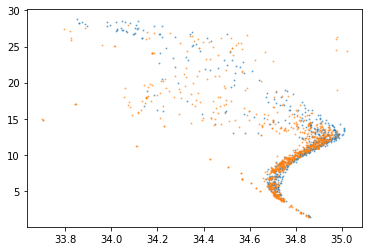

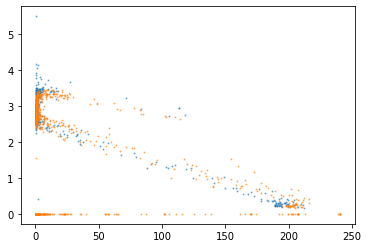

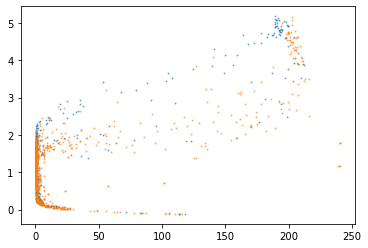

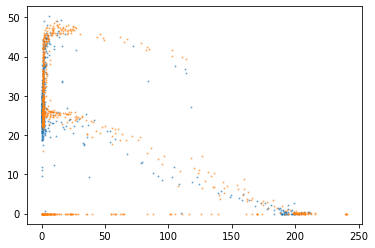

In [4]:
#sanity check by replotting some figures from Fig 3
from matplotlib import pyplot as plt

plt.scatter(falkor_df["absolute_salinity"],
            falkor_df["conservative_temp"], s=1, alpha=0.5)
plt.scatter(rr_df["absolute_salinity"],
            rr_df["conservative_temp"], s=1, alpha=0.5)
plt.show()

plt.scatter(falkor_df["oxygen"],
            falkor_df["phosphate"], s=1, alpha=0.5)
plt.scatter(rr_df["oxygen"],
            rr_df["phosphate"], s=1, alpha=0.5)
plt.show()

plt.scatter(falkor_df["oxygen"],
            falkor_df["spiciness"], s=1, alpha=0.5)
plt.scatter(rr_df["oxygen"],
            rr_df["spiciness"], s=1, alpha=0.5)
plt.show()

plt.scatter(falkor_df["oxygen"],
            falkor_df["nitrate"], s=1, alpha=0.5)
plt.scatter(rr_df["oxygen"],
            rr_df["nitrate"], s=1, alpha=0.5)
plt.show()

In [66]:
def prepare_endmember_df(endmembers_arr):
    df = pd.DataFrame(data=endmembers_arr,
                      columns=["endmember_name",
                               "conservative_temp", "absolute_salinity",
                               "oxygen", "phosphate", "spiciness"])
    df["mass"] = 1
    return df

#From table 1 in the text
                                   #Temp  Sal    Oxy     Phos     Spic
TSW_FK =         ["TSW_FK",        26.95, 34.06, 192.70, 0.223,  4.970]
ESW_FK =         ["ESW_FK",        23.28, 34.56, 212.00, 0.170,  3.800]
PSUW_proxy_FK =  ["PSUW_proxy_FK", 15.93, 34.13, 188.40, 0.437,  1.790]
CW13_FK =        ["13CW_FK",       12.54, 34.98,   0.59, 2.730,  1.580]
NEPIW_FK =       ["NEPIW_FK",       9.56, 34.80,   0.64, 3.100,  0.894]

TSW_RR =         ["TSW_RR",        26.56, 33.83, 192.70, 0.223,  4.360]
ESW_RR =         ["ESW_RR",        21.26, 34.44, 212.00, 0.170,  3.300]
PSUW_proxy_RR =  ["PSUW_proxy_RR", 16.71, 34.13, 188.40, 0.437,  1.910]
CW13_RR =        ["13CW_RR",       13.08, 34.95,   0.69, 2.730,  1.680]
NEPIW_RR =       ["NEPIW_RR",       9.56, 34.80,   0.90, 3.100,  0.894]

AAIW =           ["AAIW",           6.03, 34.70,   4.80, 3.480,  0.418]
UCDW_proxy =     ["UCDW_proxy",     1.42, 34.87, 118.00, 2.670, -0.110]


surfacewaters_FK_endmemberdf = prepare_endmember_df([
                    TSW_FK, ESW_FK, PSUW_proxy_FK,
                    CW13_FK#, NEPIW_FK, AAIW, UCDW_proxy
])

intermediatewaters_FK_endmemberdf = prepare_endmember_df([
                    #TSW_FK, ESW_FK, PSUW_proxy_FK,
                    CW13_FK, NEPIW_FK, AAIW#, UCDW_proxy
])

intermediatewaters_RR_endmemberdf = prepare_endmember_df([
                    #TSW_RR, ESW_RR, PSUW_proxy_RR,
                    CW13_RR, NEPIW_RR, AAIW#, UCDW_proxy
])

intermediatewaters_FK_endmemberdf_withpsuw = prepare_endmember_df([
                    #TSW_FK, ESW_FK,
                    PSUW_proxy_FK,
                    CW13_FK, NEPIW_FK, AAIW#, UCDW_proxy
])

intermediatewaters_RR_endmemberdf_withpsuw = prepare_endmember_df([
                    #TSW_RR, ESW_RR,
                    PSUW_proxy_RR,
                    CW13_RR, NEPIW_RR, AAIW#, UCDW_proxy
])

In [7]:
np.sum(falkor_df["spiciness"] < 0)

6

In [68]:
%reload_ext autoreload
%autoreload 2
from importlib import reload
import pyompa
reload(pyompa)

surfacewaters_falkordf = pd.DataFrame(falkor_df[(falkor_df["sigma0"] < 26.0)])
intermediatewaters_falkordf = pd.DataFrame(falkor_df[(falkor_df["sigma0"] >= 26.0)
                                                     & (falkor_df["sigma0"] <= 27.0)])
intermediatewaters_rrdf = pd.DataFrame(rr_df[(rr_df["sigma0"] >= 26.0)
                                             & (rr_df["sigma0"] <= 27.0)])

conversionratios_orig = {
    "oxygen": [-1],
    "phosphate": [1.0/170], #170 is the default redfield ratio in matlab OMPA, I also recall seeing it somewhere
}

evansorig_convertedparamgroups = [
    pyompa.ConvertedParamGroup(groupname="phosphate_remin",
                               conversion_ratios=[{"oxygen": -170, "phosphate": 1.0}],
                               always_positive=True)
]

evansorig_paramweightings = {
    "conservative_temp": 24.0,
    "absolute_salinity": 24.0,
    "spiciness": 7.0,
    "mass": 24.0,
    "oxygen": 7.0,
    "phosphate": 2.0
}

evansorig_settings = {
    "param_names": ["conservative_temp", "absolute_salinity", "spiciness", "mass", "oxygen", "phosphate"],
    "param_weightings": evansorig_paramweightings,
    "convertedparam_groups": evansorig_convertedparamgroups,
    "sumtooneconstraint": False,
    "standardize_by_watertypes": True
}

evansorig_settings_nospiciness = {
    "param_names": ["conservative_temp", "absolute_salinity", "mass", "oxygen", "phosphate"],
    "param_weightings": evansorig_paramweightings,
    "convertedparam_groups": evansorig_convertedparamgroups,
    "sumtooneconstraint": False,
    "standardize_by_watertypes": True
}

evansorig_settings_nospiciness_hardmassconstraint = {
    "param_names": ["conservative_temp", "absolute_salinity", "oxygen", "phosphate"],
    "param_weightings": evansorig_paramweightings,
    "convertedparam_groups": evansorig_convertedparamgroups,
    "sumtooneconstraint": True,
    "standardize_by_watertypes": True
}

settingname_to_surfaceompasoln = {}
settingname_to_fkintermediatesoln = {}
settingname_to_rrintermediatesoln = {}

for settingname,settings in [("evansorig_settings", evansorig_settings),
                             ("evansorig_settings_nospiciness", evansorig_settings_nospiciness),
                             ("evansorig_settings_nospiciness_hardmassconstraint",
                              evansorig_settings_nospiciness_hardmassconstraint)]:
    settingname_to_surfaceompasoln[settingname] = pyompa.OMPAProblem(
                          obs_df = surfacewaters_falkordf,
                          **settings).solve(
                              surfacewaters_FK_endmemberdf,
                              endmember_name_column="endmember_name")

    settingname_to_fkintermediatesoln[settingname] = pyompa.OMPAProblem(
          obs_df = intermediatewaters_falkordf,
          **settings).solve(intermediatewaters_FK_endmemberdf,
                            endmember_name_column="endmember_name")
    
    settingname_to_rrintermediatesoln[settingname] = pyompa.OMPAProblem(
          obs_df = intermediatewaters_rrdf,
          **settings).solve(intermediatewaters_RR_endmemberdf,
                            endmember_name_column="endmember_name")
    
settingname_to_fkintermediatesoln_withpsuw = {}
settingname_to_rrintermediatesoln_withpsuw = {}
for settingname,settings in [("evansorig_settings_nospiciness_hardmassconstraint_withpsuw",
                              evansorig_settings_nospiciness_hardmassconstraint)]:
    settingname_to_fkintermediatesoln_withpsuw[settingname] = pyompa.OMPAProblem(
          obs_df = intermediatewaters_falkordf,
          **settings).solve(intermediatewaters_FK_endmemberdf_withpsuw,
                            endmember_name_column="endmember_name")
    
    settingname_to_rrintermediatesoln_withpsuw[settingname] = pyompa.OMPAProblem(
          obs_df = intermediatewaters_rrdf,
          **settings).solve(intermediatewaters_RR_endmemberdf_withpsuw,
                            endmember_name_column="endmember_name")

I'm assuming that the index encoding mass is: [3]
Std used for normalization: [ 5.71959133  0.36955209  1.41390417  1.         85.81265069  1.06701664]
Mean used for normalization: [ 19.675   34.4325   3.035    0.     148.4225   0.89  ]
params to use: ['conservative_temp', 'absolute_salinity', 'spiciness', 'mass', 'oxygen', 'phosphate']
param weighting: [24. 24.  7. 24.  7.  2.]
effective weighting: [7.33637028e-01 1.75735664e+02 3.50153192e+00 2.40000000e+01
 9.50594737e-04 1.75665961e+00]
Conversion ratios:
OrderedDict([('phosphate_remin', defaultdict(<class 'list'>, {'oxygen': [-170], 'phosphate': [1.0]}))])
Trying convertedvariable sign constraint: [1]
status: optimal
optimal value 1789.1868520044525
Original weighted sum squares: 1789.186852013639
Post fix weighted sum squared: 1789.1868520242692
status: optimal
optimal value 1789.1868520044525
Original weighted sum squares: 1789.186852013639
Post fix weighted sum squared: 1789.1868520242692
objective: 1789.1868520242692
I'm assum

status: optimal
optimal value 225273.67705137888
Original weighted sum squares: 225273.67736798708
Post fix weighted sum squared: 225273.67773901025
objective: 225273.67773901025
I'm assuming that the index encoding mass is: []
Std used for normalization: [ 3.65547876  0.31791312 80.72732108  1.18461668]
Mean used for normalization: [11.015   34.6525  48.6075   2.43675]
params to use: ['conservative_temp', 'absolute_salinity', 'oxygen', 'phosphate']
param weighting: [24. 24.  7.  2.]
effective weighting: [1.79606773e+00 2.37462124e+02 1.07413028e-03 1.42519505e+00]
Conversion ratios:
OrderedDict([('phosphate_remin', defaultdict(<class 'list'>, {'oxygen': [-170], 'phosphate': [1.0]}))])
Trying convertedvariable sign constraint: [1]
status: optimal
optimal value 1199.8025720993041
Original weighted sum squares: 1199.8025723897408
Post fix weighted sum squared: 1199.802572782651
status: optimal
optimal value 1199.8025720993041
Original weighted sum squares: 1199.8025723897408
Post fix wei

Falkor
evansorig_settings


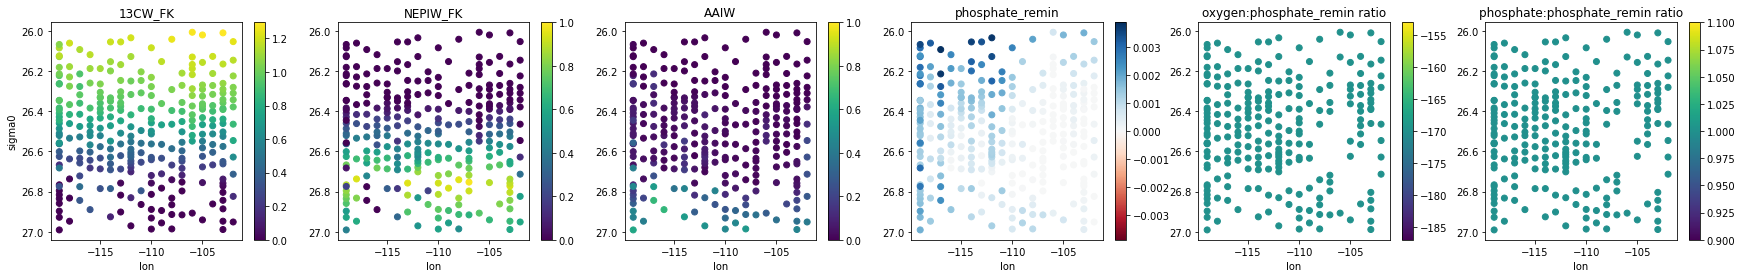

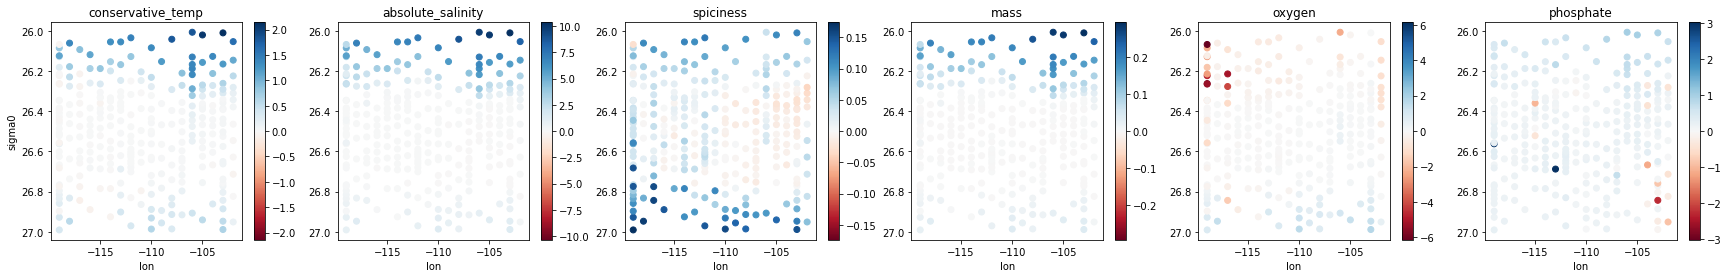

evansorig_settings_nospiciness


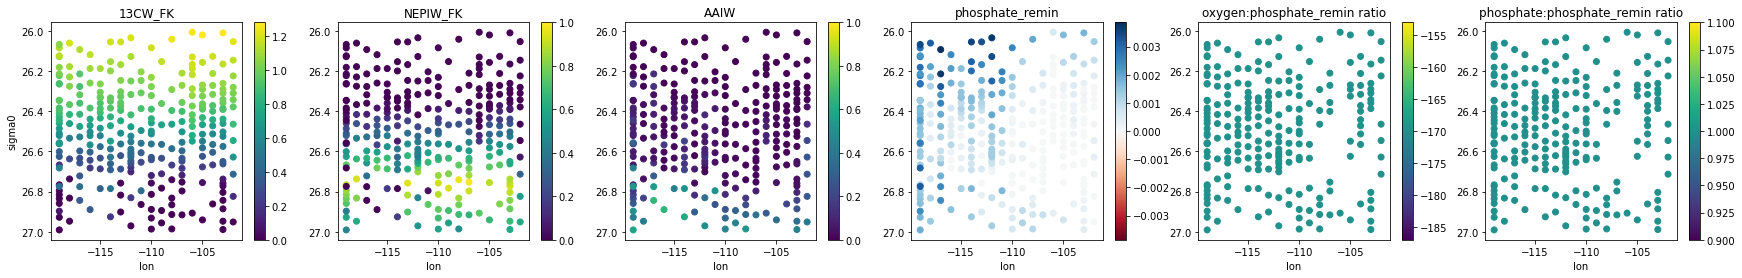

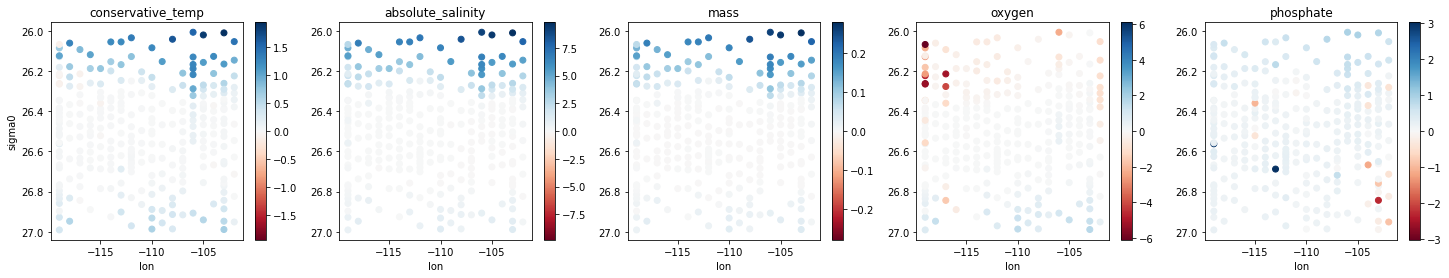

evansorig_settings_nospiciness_hardmassconstraint


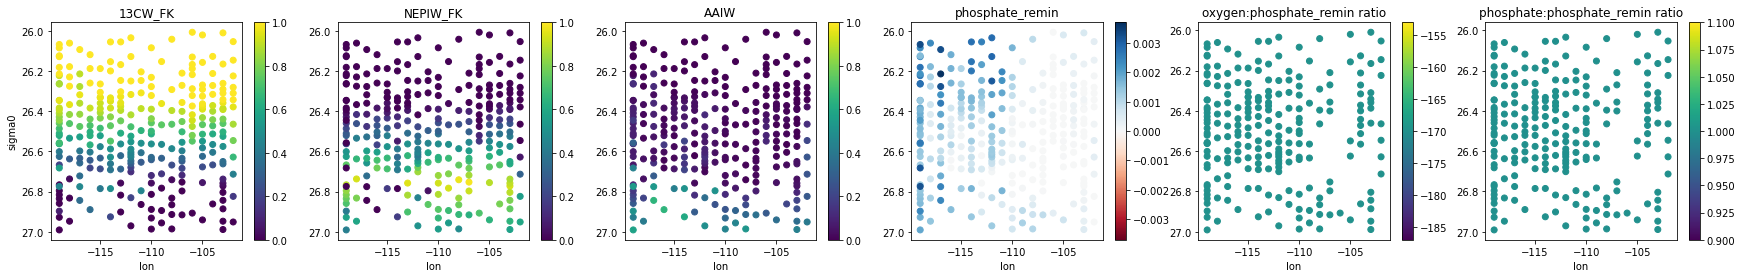

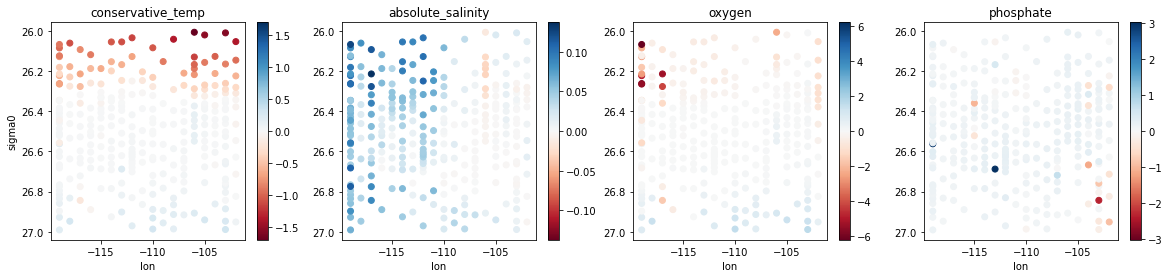

Falkor with PSUW
evansorig_settings_nospiciness_hardmassconstraint_withpsuw


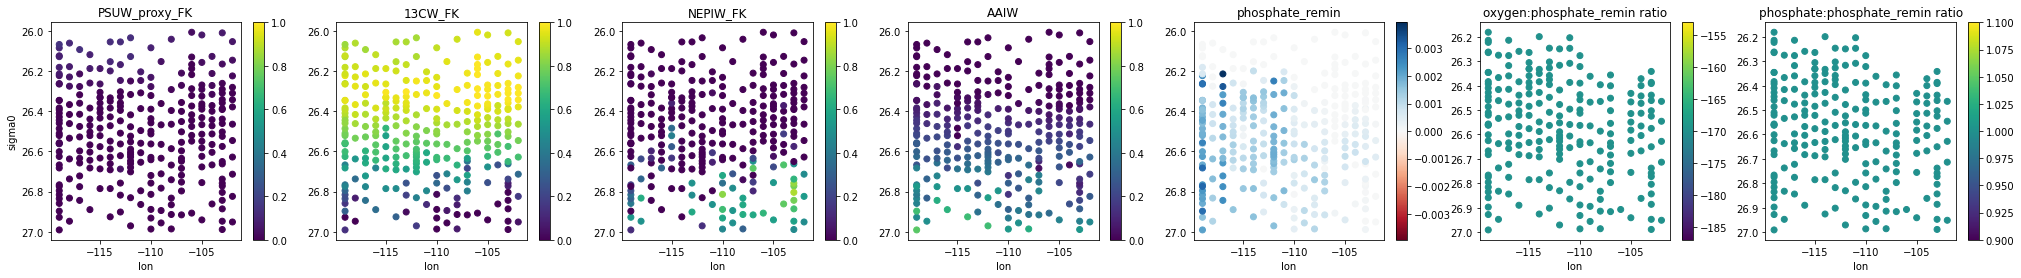

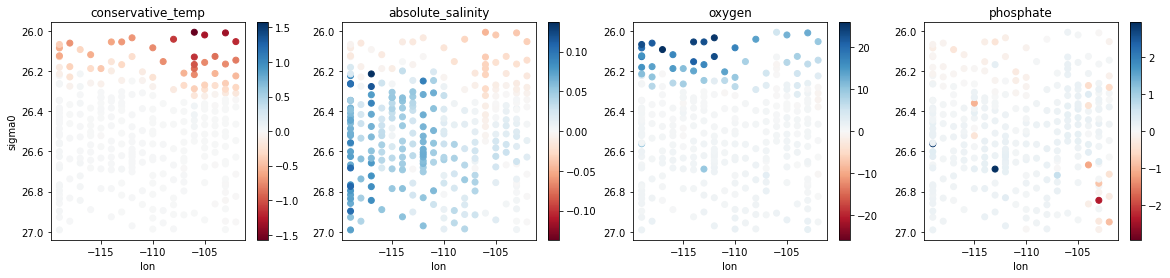

RR
evansorig_settings


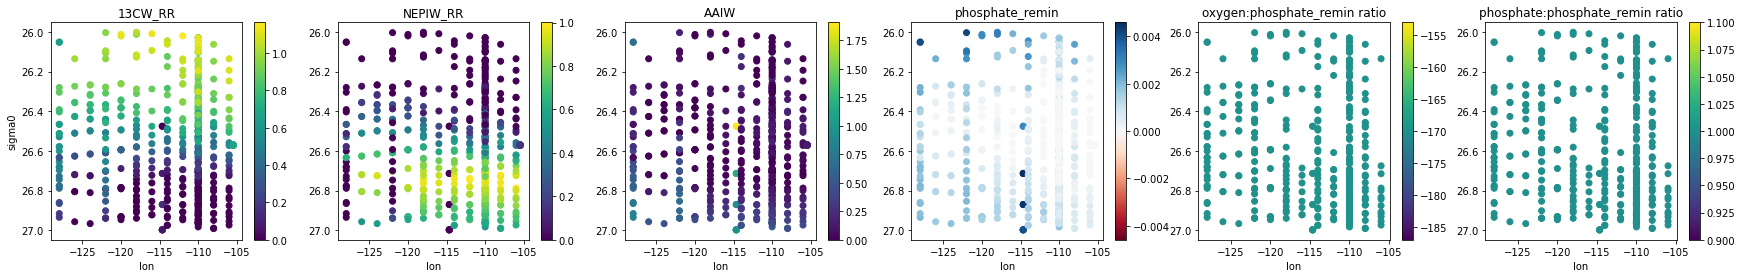

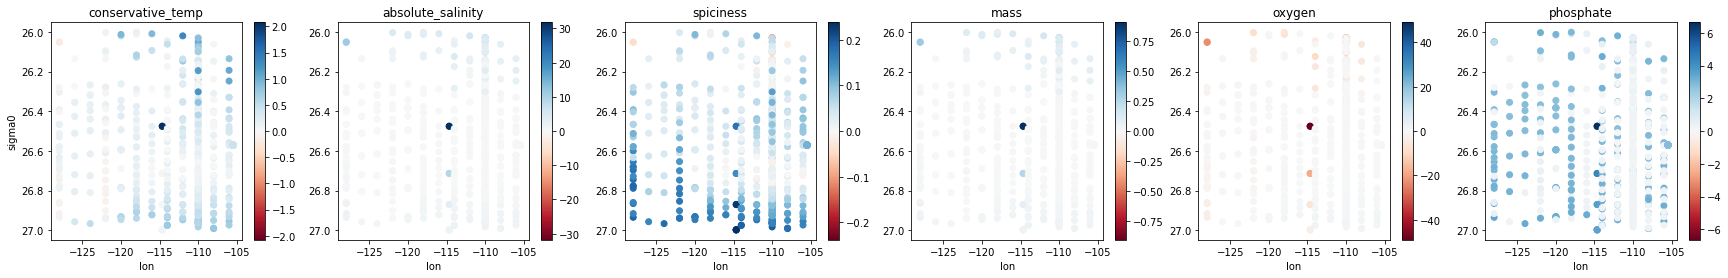

evansorig_settings_nospiciness


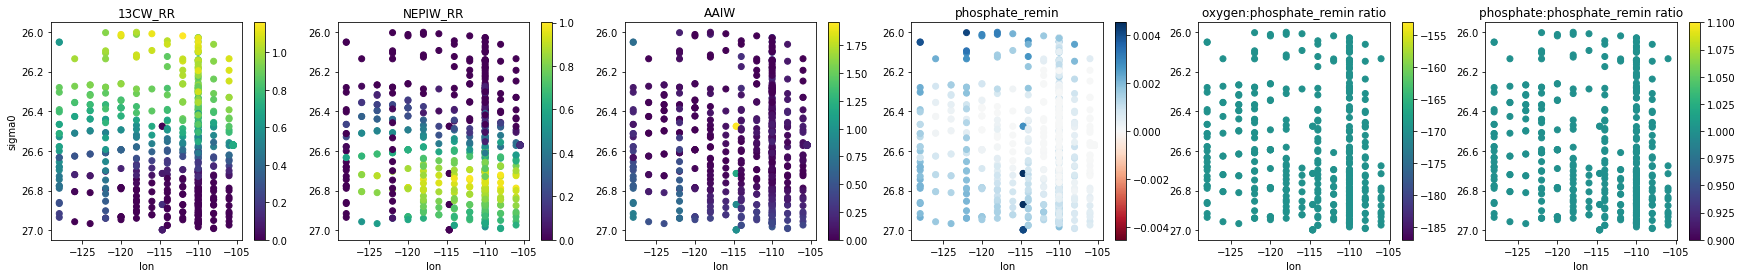

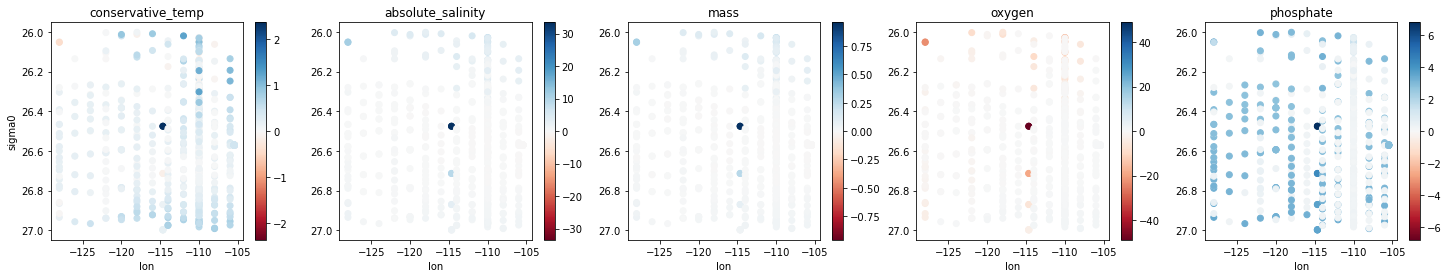

evansorig_settings_nospiciness_hardmassconstraint


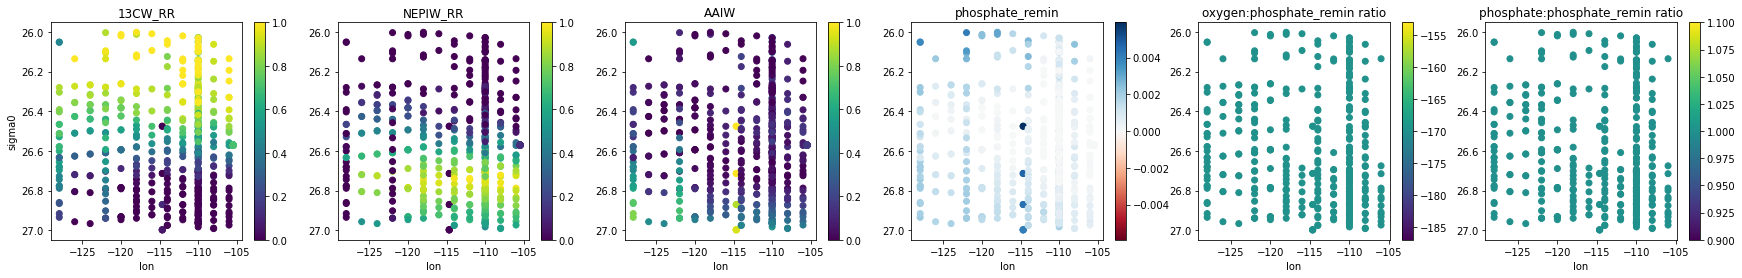

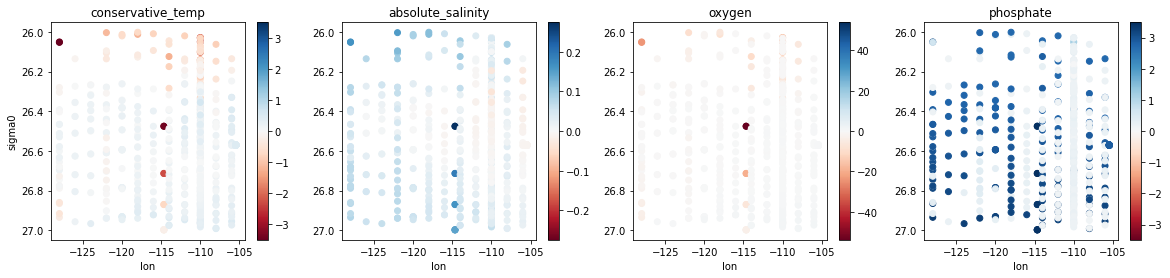

RR with PSUW
evansorig_settings_nospiciness_hardmassconstraint_withpsuw


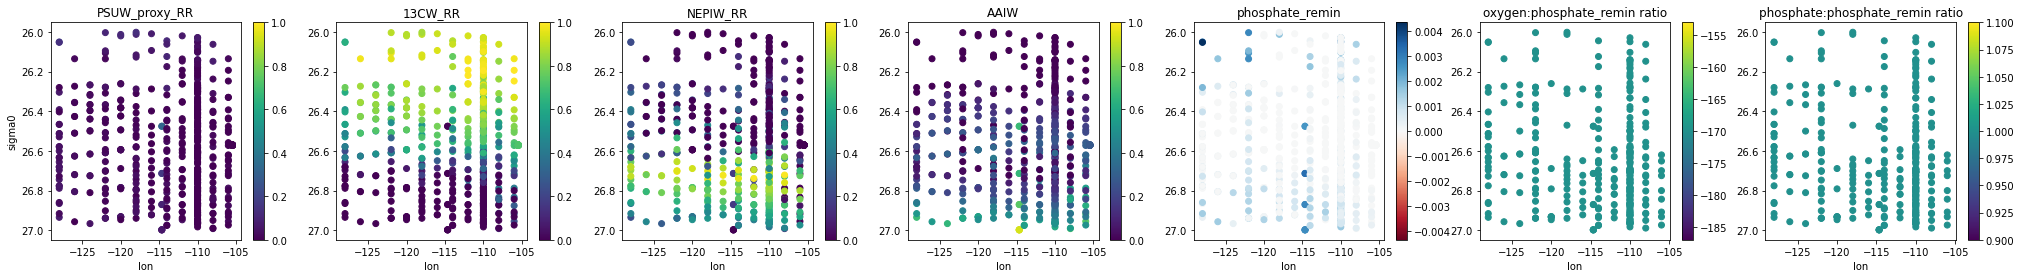

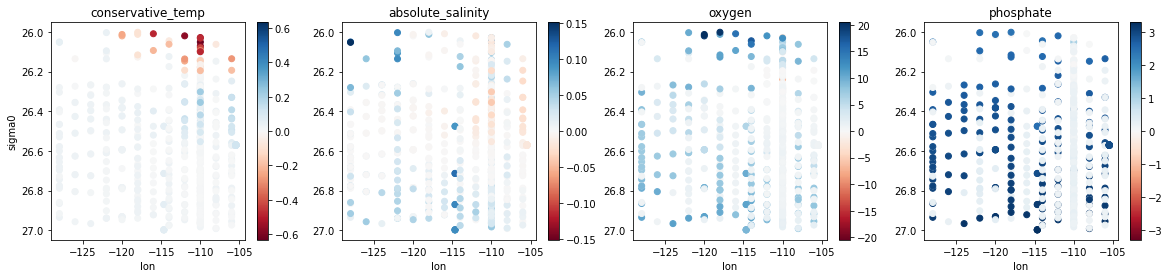

Falkor surface
evansorig_settings


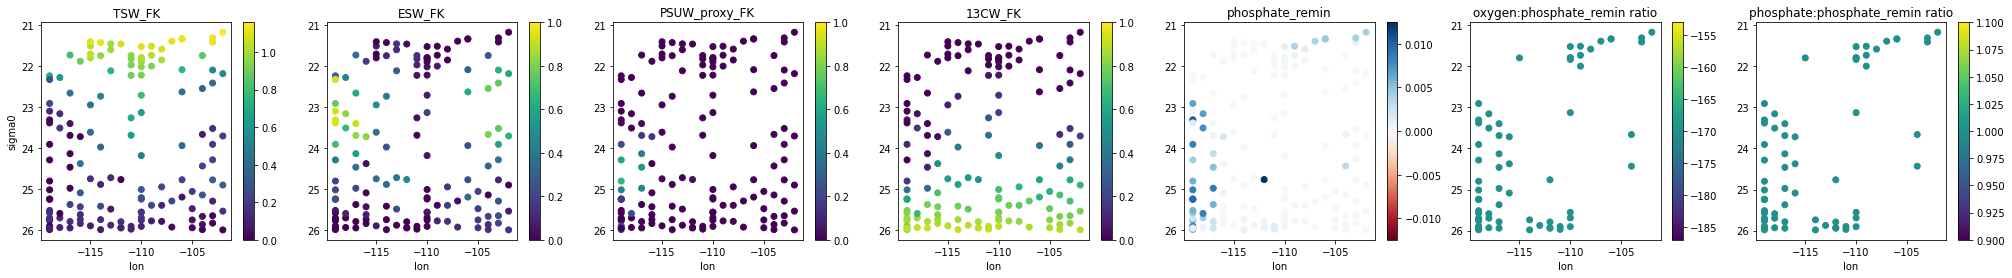

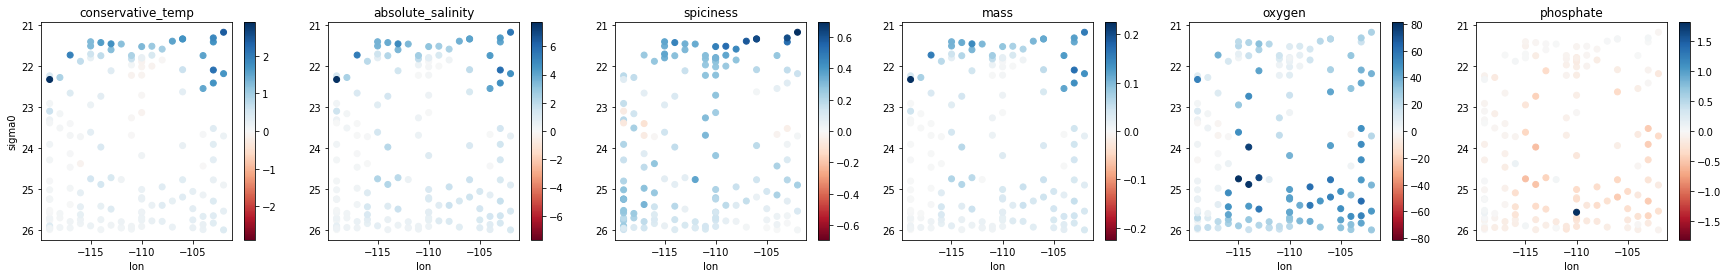

evansorig_settings_nospiciness


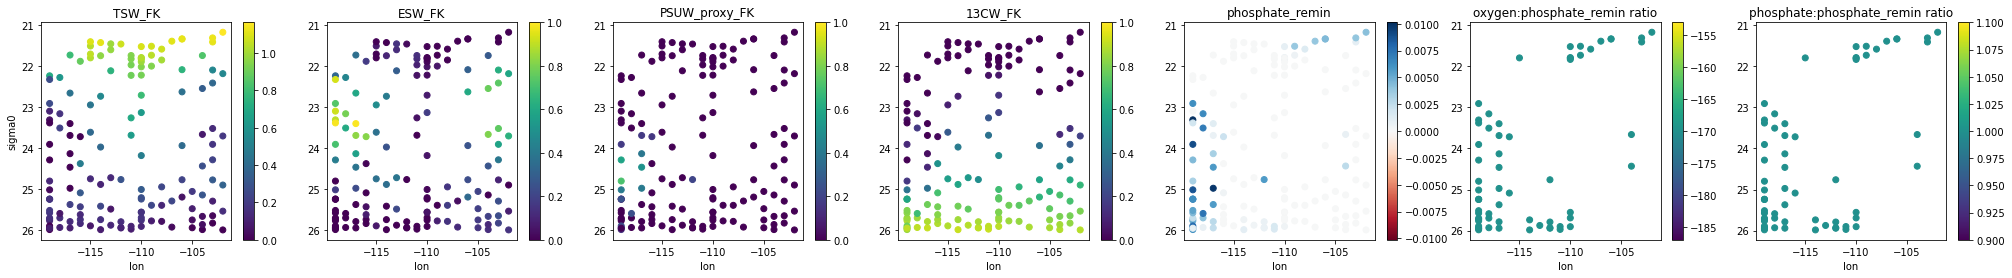

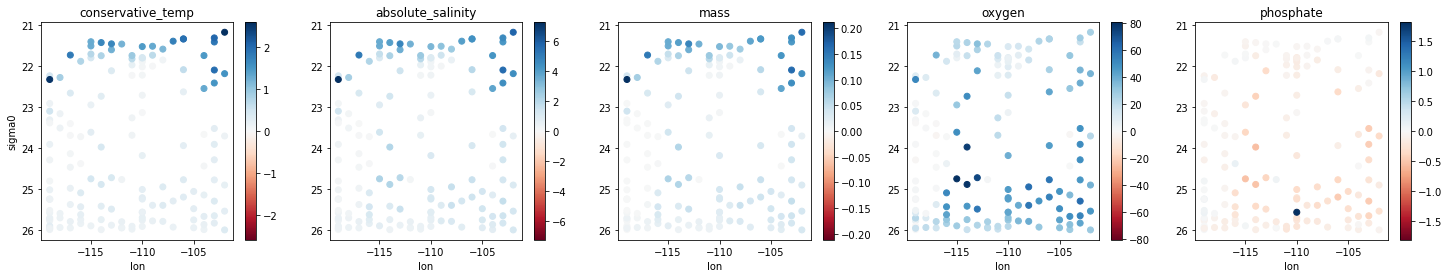

evansorig_settings_nospiciness_hardmassconstraint


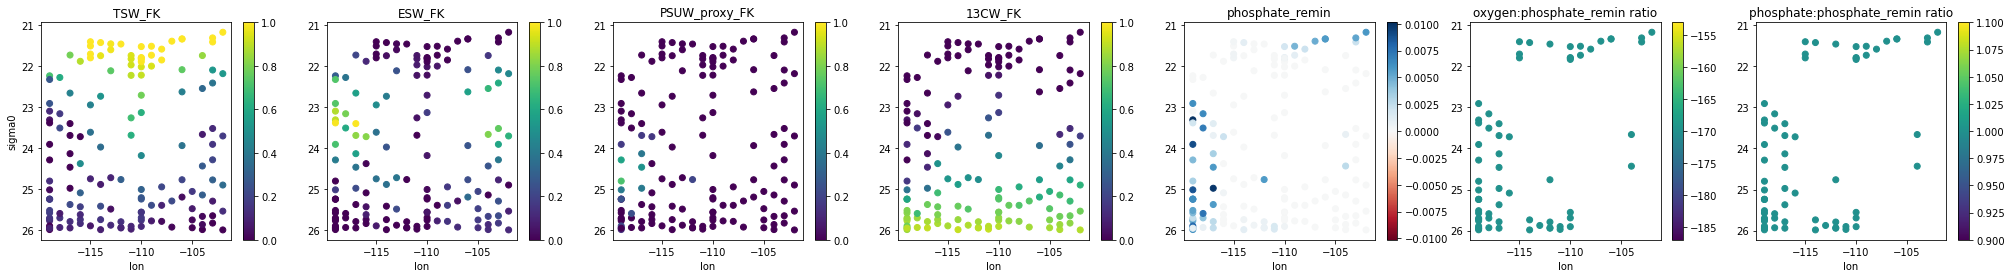

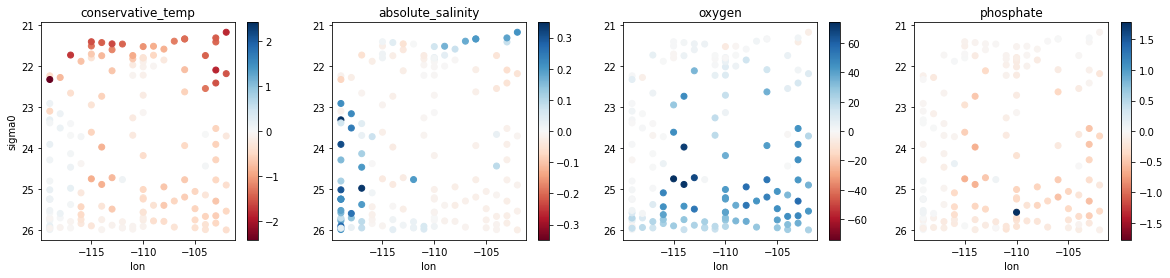

In [72]:
from matplotlib import pyplot as plt
from pyompa import (plot_ompasoln_endmember_fractions,                       
                    plot_ompasoln_residuals,                                 
                    plot_ompasoln_endmember_usagepenalties)

print("Falkor")
for settingname in settingname_to_fkintermediatesoln:
    print(settingname)
    ompa_soln = settingname_to_fkintermediatesoln[settingname]
    plot_ompasoln_endmember_fractions(ompa_soln=ompa_soln,
                                      xaxis_colname="lon",
                                      yaxis_colname="sigma0")
    plot_ompasoln_residuals(ompa_soln=ompa_soln,
                            xaxis_colname="lon",
                            yaxis_colname="sigma0")
    
print("Falkor with PSUW")
for settingname in settingname_to_fkintermediatesoln_withpsuw:
    print(settingname)
    ompa_soln = settingname_to_fkintermediatesoln_withpsuw[settingname]
    plot_ompasoln_endmember_fractions(ompa_soln=ompa_soln,
                                      xaxis_colname="lon",
                                      yaxis_colname="sigma0")
    plot_ompasoln_residuals(ompa_soln=ompa_soln,
                            xaxis_colname="lon",
                            yaxis_colname="sigma0")
    
print("RR")
for settingname in settingname_to_rrintermediatesoln:
    print(settingname)
    ompa_soln = settingname_to_rrintermediatesoln[settingname]
    plot_ompasoln_endmember_fractions(ompa_soln=ompa_soln,
                                      xaxis_colname="lon",
                                      yaxis_colname="sigma0")
    plot_ompasoln_residuals(ompa_soln=ompa_soln,
                            xaxis_colname="lon",
                            yaxis_colname="sigma0")
    

    
print("RR with PSUW")
for settingname in settingname_to_rrintermediatesoln_withpsuw:
    print(settingname)
    ompa_soln = settingname_to_rrintermediatesoln_withpsuw[settingname]
    plot_ompasoln_endmember_fractions(ompa_soln=ompa_soln,
                                      xaxis_colname="lon",
                                      yaxis_colname="sigma0")
    plot_ompasoln_residuals(ompa_soln=ompa_soln,
                            xaxis_colname="lon",
                            yaxis_colname="sigma0")

print("Falkor surface")
for settingname in settingname_to_surfaceompasoln:
    print(settingname)
    ompa_soln = settingname_to_surfaceompasoln[settingname]
    plot_ompasoln_endmember_fractions(ompa_soln=ompa_soln,
                                      xaxis_colname="lon",
                                      yaxis_colname="sigma0")
    plot_ompasoln_residuals(ompa_soln=ompa_soln,
                            xaxis_colname="lon",
                            yaxis_colname="sigma0")

In [73]:
!pwd

/Users/avantishrikumar/Research/pyompa/examples
